## Setup

In [1]:
import stan
import pandas as pd
import numpy as np
import scipy.stats as stats 
import matplotlib
import matplotlib.pyplot as plt
import arviz as az
#matplotlib.rcParams['figure.figsize']=5,5
matplotlib.rcParams['figure.dpi']=100
#plt.style.use('ggplot')

In [2]:
# this is a work around found at 
# https://stackoverflow.com/questions/56154176/runtimeerror-asyncio-run-cannot-be-called-from-a-running-event-loop-in-spyd
import nest_asyncio
nest_asyncio.apply()

##### Likelihood in a Mixture Model:

$$ p(x_n|\Theta) = \sum_{k=1}^{K} \, \pi_k \, p(x_n|\theta_k)$$


$$ \log p(X|\Theta) = \sum_{n=1}^{N} \, \log(\, \sum_{k=1}^{K} \, \pi_k \, p(x|\theta_k) \, )$$ 



## Truncated curves exploration

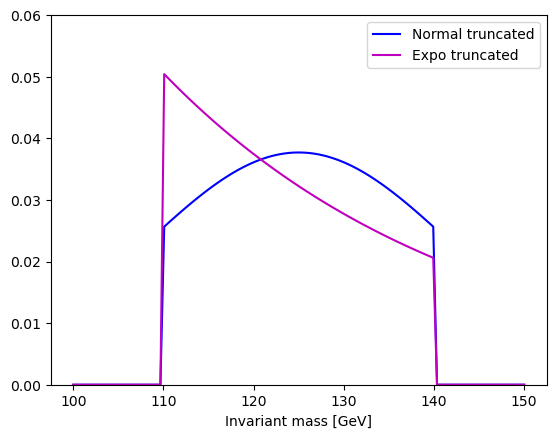

In [3]:
x = np.linspace(100,150,120)
mu = 125
sigma = 17
plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', label='Normal truncated')
b = 30
Lambda = 0.03
plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', label = 'Expo truncated')
plt.ylim(0,0.06)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

In [4]:
sum(stats.truncnorm.pdf(x,(110-125)/17,(140-125)/17,125,17))*50/120

0.9980516360413421

In [5]:
sum(stats.truncexpon.pdf(x-110,30*0.03, loc=0, scale = 1/0.03))*50/120

1.0005555373368886

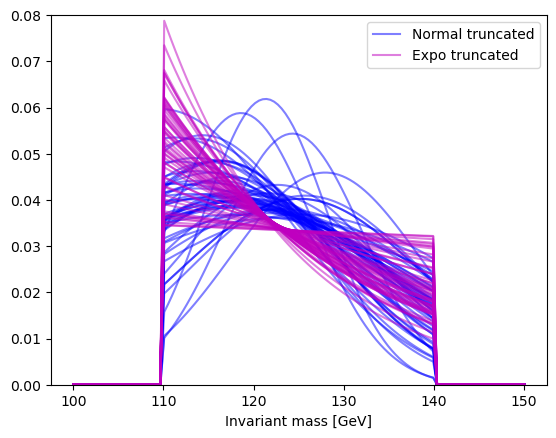

In [6]:
x = np.linspace(100,150,120)
np.random.seed(1)
for i in range(50):
    mu = np.random.normal(117,5)
    sigma = np.random.normal(16,4)
    if i==0: plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5, label='Normal truncated')
    plt.plot(x,stats.truncnorm.pdf(x,(110-mu)/sigma,(140-mu)/sigma,mu,sigma), 'b-', alpha=0.5)
for j in range(50):
    b = 30
    Lambda = abs(np.random.normal(0.03,0.02))
    if j==0: plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-', alpha=0.5, label = 'Expo truncated')
    plt.plot(x,stats.truncexpon.pdf(x-110,b*Lambda, loc=0, scale = 1/Lambda), 'm-',  alpha=0.5)
plt.ylim(0,0.08)
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

## Generate synthetic data

In [18]:
b=30
Lambda = 0.06
mu=120
sigma=7
###################
data = []
p = [0.5,0.5] # p[0]: background, p[1]: signal
np.random.seed(seed=0)
for i in range(500):
    if np.random.binomial(1,p[1], size=1)[0] == 1: # We sample a binomial with p[1], hence it is 1 if it is signal
        data.append(list(stats.truncnorm.rvs((110-mu)/sigma,(140-mu)/sigma,mu,sigma, size=2))+[1])
    else:
        data.append(list(stats.truncexpon.rvs(b = b*Lambda,   loc=110, scale = 1/Lambda, size=2))+[0])
        

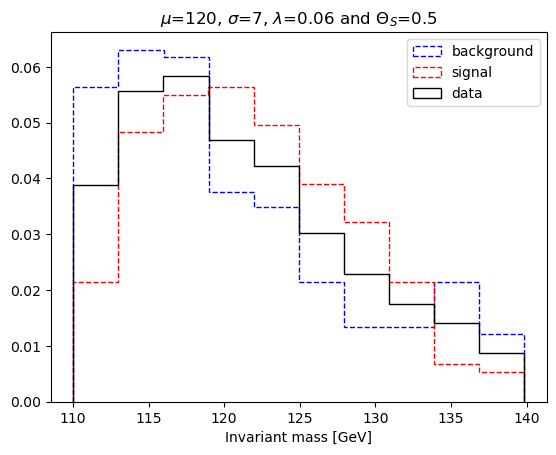

In [19]:
plt.hist([x[1] for x in data if x[2]==0], histtype='step', linestyle='dashed', color='blue', density=1, label = 'background')
plt.hist([x[1] for x in data if x[2]==1],histtype='step', linestyle='dashed', color='red',  density=1, label='signal')
plt.hist([x[1] for x in data],histtype='step', density=1, color='black', label='data')
plt.xlabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

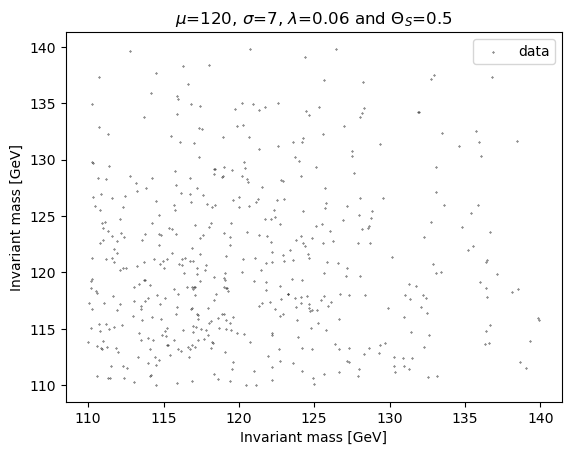

In [20]:
plt.scatter([x[0] for x in data], [x[1] for x in data], color='black', s=0.1, label='data')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

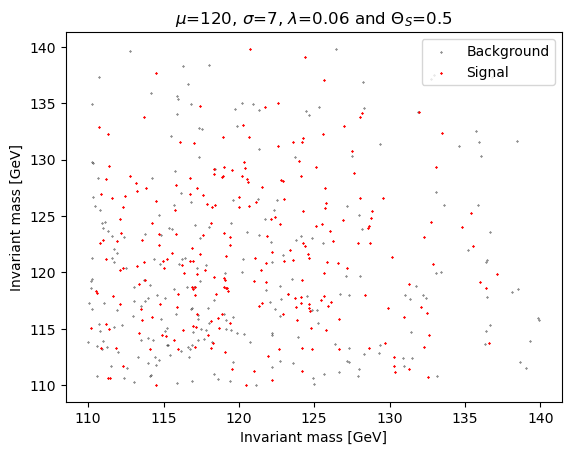

In [21]:
plt.scatter([x[0] for x in data if x[2]==0], [x[1] for x in data if x[2]==0], color='black', s=0.1, label='Background')
plt.scatter([x[0] for x in data if x[2]==1], [x[1] for x in data if x[2]==1], color='red', marker='x', s=0.5, label='Signal')
plt.xlabel('Invariant mass [GeV]')
plt.ylabel('Invariant mass [GeV]')
plt.title('$\mu$='+str(mu)+', $\sigma$='+str(sigma)+', $\lambda$='+str(Lambda)+' and $\Theta_S$='+str(p[1]))
plt.legend()
plt.show()

## Stan inference

In [22]:
my_model = """
data {
 int <lower=0> N; // number of datapoints
 real L, U; // lower and upper limits of the observables (i.e. how to truncate the distributions)
 array[N,2] real<lower=L, upper=U> y;  // there are 2 observables per datapoint
 real mu0, sigma0, mu1, sigma1, mu2, sigma2, t1, t2;  // hyperparameters for the parameters priors
}

parameters {
  real<lower=0> mu; 
  real<lower=0> sigma;
  real<lower=0> lambda0;
  simplex[2] theta;  
}

model {
    vector[2] lp;
    mu ~ normal(mu0, sigma0);
    sigma ~ cauchy(mu1, sigma1);
    lambda0 ~ normal(mu2, sigma2);
    theta ~ dirichlet([t1,t2]);
    
   for (n in 1:N) {
     lp[1] =   normal_lpdf(y[n,1] | mu, sigma)
             - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) )             
             + normal_lpdf(y[n,2] | mu, sigma)
             - log_diff_exp( normal_lcdf( U | mu, sigma), normal_lcdf( L | mu, sigma) );
     lp[2] =   exponential_lpdf( y[n,1] - L | lambda0)             
             - exponential_lcdf( U - L | lambda0) 
             + exponential_lpdf( y[n,2] - L| lambda0)
             - exponential_lcdf( U - L | lambda0);
     target += log_mix(theta, lp);                        
     };
}
"""

In [23]:
# Define hyperparameters that determine priors
mu0 = 120
sigma0 = 6
mu1 = 8
sigma1 =5
mu2 = Lambda*0.8
sigma2 = Lambda*0.2       
t1 = 1
t2 = 1

In [24]:
passed_data = [[x[0], x[1]] for x in data]
my_data = {'N': len(passed_data), 
           'y': passed_data, # Only first 2 columns. I.e. not the class.
           'mu0': mu0,
           'sigma0': sigma0,
           'mu1':mu1,
           'sigma1': sigma1,
           'mu2': mu2,
           'sigma2': sigma2,
           't1' : t1,
           't2' : t2,
           'L' : 110.0,
           'U' : 140.0
          }

In [25]:
model = stan.build(my_model, data=my_data, random_seed=0);

Building: 0.2s


Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_zpf_apnr/model_242gmyjy.stan', line 21, column 4: The
    parameter theta is on the left-hand side of more than one tilde
    statement.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [26]:
fit = model.sample(num_chains=4, num_samples=1000, delta=0.8)


Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/sequi/miniconda3/envs/stan3/lib/python3.10/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/home/sequi/.local/lib/python3.10/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: write: Broken pipe [system:32]
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe [system:32]
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   6% (502/8000)
Sampling:   8% (602/8000)
Sampling:  10% (802/8000)
Sampling:  14% (1102/8000)
Sa

## Analyze results

In [27]:
df = fit.to_frame() 
df

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,mu,sigma,lambda0,theta.1,theta.2
draws,,,,,,,,,,,,
0,-3259.010290,0.982404,0.184950,4.0,31.0,0.0,3260.303477,118.225558,8.480267,0.043505,0.599449,0.400551
1,-3261.779239,0.882925,0.226209,4.0,19.0,0.0,3264.189281,119.989489,8.218458,0.052072,0.500102,0.499898
2,-3259.856940,0.970024,0.226348,4.0,15.0,0.0,3261.630124,119.648058,6.719621,0.056386,0.395637,0.604363
3,-3260.700899,0.999826,0.206213,4.0,15.0,0.0,3261.515183,115.060113,11.323688,0.050467,0.802643,0.197357
4,-3263.630765,0.855773,0.184950,4.0,23.0,0.0,3266.962807,115.378661,11.320313,0.025162,0.828464,0.171536
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-3258.907515,0.983489,0.206213,4.0,23.0,0.0,3259.617397,117.031566,9.698399,0.045901,0.784008,0.215992
3996,-3262.311833,0.913506,0.184950,4.0,15.0,0.0,3264.774822,117.125808,10.391080,0.034316,0.956789,0.043211
3997,-3261.635304,1.000000,0.226209,3.0,7.0,0.0,3262.613990,118.215037,7.140891,0.032854,0.489568,0.510432


In [28]:
# Let's diagnose the sampling.  rhat is a variable that measures how good the chains have reached a stationary state
# rhat < 1.05 is good enough
azdata = az.from_pystan(fit)
summary = az.summary(azdata)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda0,0.047,0.010,0.028,0.066,0.000,0.000,1914.0,1860.0,1.0
mu,117.371,1.419,114.669,119.950,0.046,0.032,968.0,1493.0,1.0
sigma,9.219,1.460,6.635,11.962,0.048,0.034,927.0,1615.0,1.0
theta[0],0.701,0.162,0.443,1.000,0.005,0.004,911.0,1120.0,1.0
theta[1],0.299,0.162,0.000,0.557,0.005,0.004,911.0,1120.0,1.0


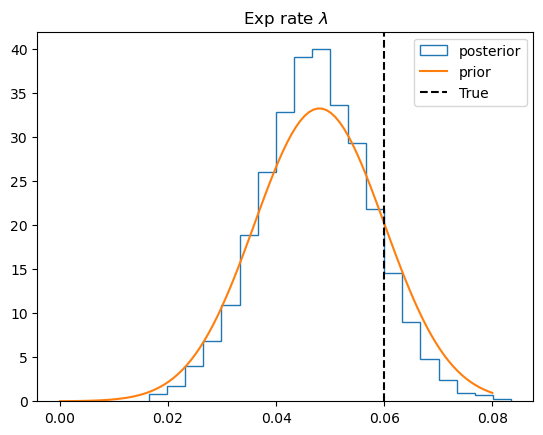

In [29]:
x=np.linspace(0,0.08,100)
plt.hist(df['lambda0'], histtype='step', density=1, bins=20, label='posterior')
plt.plot(x, stats.norm.pdf(x, mu2, sigma2), label='prior')
plt.axvline(x=Lambda, linestyle='dashed', color='black', label='True')
plt.title('Exp rate $\lambda$')
plt.legend()
plt.show()

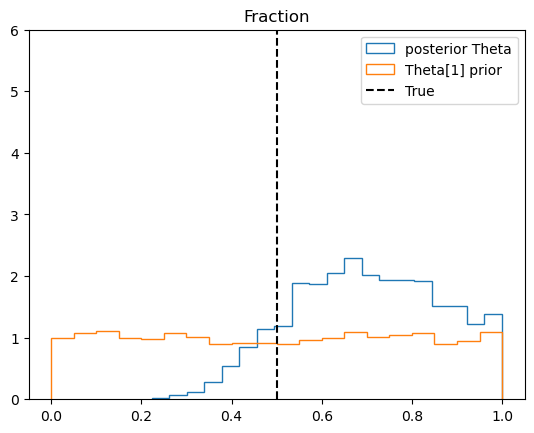

In [30]:
x=np.linspace(0,0.15,100)
tmp = np.random.dirichlet([t1,t2], size=5000)
plt.hist(df['theta.1'], histtype='step', density=1, bins=20, label='posterior Theta')
plt.hist([x[0] for x in tmp], density=1, histtype='step', bins=20, label='Theta[1] prior')
#plt.hist([x[1] for x in tmp], density=1, histtype='step', bins=20, label='Theta[2] prior')
plt.axvline(x=p[1], linestyle='dashed', color='black', label='True')
plt.ylim(0,6)
plt.title('Fraction')
plt.legend()
plt.show()

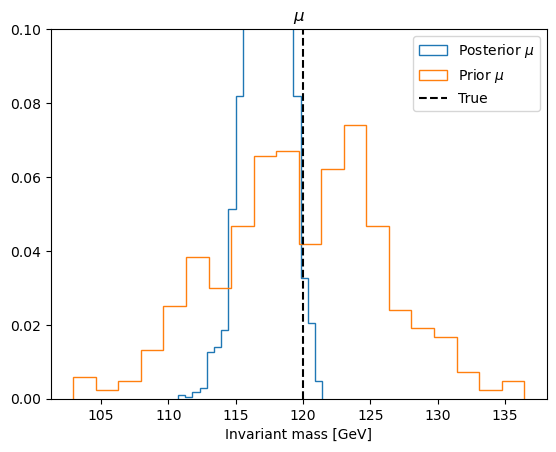

In [31]:
x=np.linspace(100,150,100)
plt.hist(df['mu'], histtype='step', density=1, bins=20, label='Posterior $\mu$')
plt.hist([x for x in np.random.normal(mu0,sigma0,size=500)], density=1, histtype='step', bins=20, label='Prior $\mu$')
plt.axvline(x=mu, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.1)
plt.title('$\mu$')
plt.xlabel('Invariant mass [GeV]')
plt.legend()
plt.show()

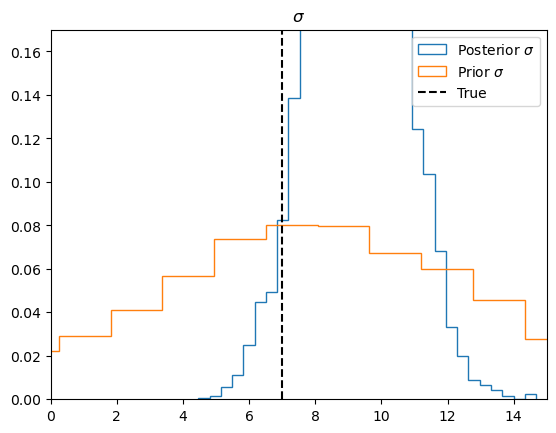

In [32]:
x=np.linspace(0,15,100)
plt.hist(df['sigma'], histtype='step', density=1, bins=30, label='Posterior $\sigma$')
plt.hist([x for x in np.random.normal(mu1,sigma1,size=1500)], density=1, histtype='step', bins=20, label='Prior $\sigma$')
plt.axvline(x=sigma, linestyle='dashed', color='black', label='True')
plt.ylim(0,0.17)
plt.xlim(0,15)
plt.title('$\sigma$')
plt.legend()
plt.show()